# Running mokapot

Change output df to "pin" format
<br>[fibertools/fiberdata.py make_percolator_input](https://github.com/fiberseq/fibertools/blob/5fafd4301ef28a17027d2c4d5b6ef61b950fd3f9/fibertools/fiberdata.py#L129-L170)

* give a fake peptide column name
* add an ID column peptide (of unique IDs)
* col 1. Label
    * label in the 1st position
    * give things within ChIP-seq peaks = 1 (positive data)
    * not within a ChIP-seq peak = -1 (negative data)
    * I will have no 0 values
* SpecId
    * set index of df (0 - now)
    * copy to cols: peptide, proteins, scanner
    * do NOT need log_msp_len

Passing pin df to mokapot
<br>[fibertools/classify.py make_accessibility_model](https://github.com/fiberseq/fibertools/blob/5fafd4301ef28a17027d2c4d5b6ef61b950fd3f9/fibertools/classify.py#L154-L181)

* don't need train pin subsetting `train = mokapot.read_pin(pin_df`
* train_psms `psms = peptide spectrum match, used in proteomics`
* scale_pos_weight (hyper parameter for XGBoost on how to weigh positive vs negative labels based on frequency in the data)
* grid
    * n_estimators: how many decision trees to use (~100 is normal)
    * scale_pos_weight: weighing for imbalanced data
    * max_depth: depth of tree
    * min_child_weight: min # of rows needed to touch a terminal leaf for a leaf to be retained
    * gamma: learning rate, gradient descent algorithm, slow = risk of overfitting, fast: generalizes to new data better

In [8]:
import os
import pandas as pd
import numpy as np

fibertools installed without dependencies

In [9]:
import mokapot
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [10]:
# set folders
project_dir = "/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting"
data_dir = "{}/feature_data".format(project_dir)

## convert feature table to pin format

### make_percolator_input

need to add the following columns: [SpecID, Label, Peptide, Proteins]

#### format positive data

In [245]:
# CTCF L (best footprint according to Andrew)
data_type = "positive"
motif_type = "L"
data_file = "{}/CTCF_{}_m6a_fiberseq_{}_100bp_features.txt".format(data_dir, data_type, motif_type)

In [247]:
label_val = 1 if "positive" in data_file else -1

In [251]:
data_file.split(".")[0] + ".pin"

'/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_positive_m6a_fiberseq_L_100bp_features.pin'

In [186]:
%%time

# read in feature df
n_rows = None
df = pd.read_csv(data_file, sep="\t", nrows=n_rows)
print("rows: {:,} | cols: {:,}".format(df.shape[0], df.shape[1]))

rows: 238,348 | cols: 128
CPU times: user 1.58 s, sys: 139 ms, total: 1.72 s
Wall time: 1.73 s


In [187]:
df.head()

,motif_name,query_name,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TGT_count,TGT_m6a_prop,TTA_count,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop
0,chr10_100338605_+,m54329U_210323_190418/12585455/ccs,200.0,13.0,13.0,3.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333
1,chr10_100338605_+,m54329U_210323_190418/16515087/ccs,212.0,12.0,12.0,4.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667
2,chr10_100338605_+,m54329U_210323_190418/169477611/ccs,181.0,10.0,12.0,2.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000
3,chr10_100338605_+,m54329U_210323_190418/173999297/ccs,134.0,9.0,11.0,8.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667
4,chr10_100338605_+,m54329U_210323_190418/180160021/ccs,194.0,12.0,12.0,1.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333


In [188]:
d = df.copy(deep=True)

# add Label col of 0's
d.insert(1, "Label", 0)

# make Label value 1 for positive data
d["Label"] = d["Label"].replace(0, 1)
print("rows: {:,} | cols: {:,}".format(d.shape[0], d.shape[1]))

rows: 238,348 | cols: 129


In [189]:
# add and drop columns needed for mokapot

# remove non-feature columns
to_remove = ["motif_name", "query_name"]
d.drop(to_remove, axis=1, inplace=True)

# create SpecID col with unique ID's (set to index for now)
d.insert(0, "SpecID", d.index)
d["Peptide"] = d.SpecID
d["Proteins"] = d.SpecID
d["scannr"] = d.SpecID

print("rows: {:,} | cols: {:,}".format(d.shape[0], d.shape[1]))

rows: 238,348 | cols: 131


In [190]:
d.head()

,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop,Peptide,Proteins,scannr
0,0,1,200.0,13.0,13.0,3.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,0,0,0
1,1,1,212.0,12.0,12.0,4.0,18.0,18.0,13.0,0.45,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,1,1,1
2,2,1,181.0,10.0,12.0,2.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,2,2,2
3,3,1,134.0,9.0,11.0,8.0,18.0,18.0,13.0,0.45,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,3,3,3
4,4,1,194.0,12.0,12.0,1.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,4,4,4


#### save features to pin file

In [191]:
data_type = "positive"

In [192]:
# Percolator tab-delimited format
pin_file = "{}/CTCF_{}_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, data_type, motif_type)
d.to_csv(pin_file, sep="\t", header=True, index=False)
print("Saved pin file to: {}".format(pin_file))

Saved pin file to: /mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_positive_m6a_fiberseq_L_100bp_features.pin


### format negative data

In [193]:
# negative CTCF L
data_type = "negative"
motif_type = "L"
data_file = "{}/CTCF_{}_m6a_fiberseq_{}_100bp_small_features.txt".format(data_dir, data_type, motif_type)

In [194]:
%%time

# read in feature df
n_rows = None
df = pd.read_csv(data_file, sep="\t", nrows=n_rows)
print("rows: {:,} | cols: {:,}".format(df.shape[0], df.shape[1]))

rows: 65,943 | cols: 128
CPU times: user 476 ms, sys: 23.9 ms, total: 500 ms
Wall time: 504 ms


In [34]:
df.head()

,motif_name,query_name,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TGT_count,TGT_m6a_prop,TTA_count,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop
0,chr10_100001134_+,m54329U_210326_192251/136053044/ccs,154.0,6.0,0.0,1.0,16.0,14.0,16.0,0.400,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.000000
1,chr10_100009901_+,m54329U_210813_020940/108857329/ccs,268.0,6.0,6.0,4.0,9.0,10.0,7.0,0.225,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,chr10_100076460_+,m64076_210328_012155/112330052/ccs,69.0,1.0,10.0,8.0,22.0,22.0,15.0,0.550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,chr10_100085646_-,m54329U_210810_004956/12124794/ccs,55.0,2.0,3.0,5.0,22.0,23.0,15.0,0.550,...,0.0,0.0,1.0,0.0,1.0,0.5,1.0,0.5,1.0,0.333333
4,chr10_100118172_-,m64076_221119_202646/24772945/ccs,71.0,2.0,6.0,3.0,30.0,25.0,16.0,0.750,...,1.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000


In [195]:
d = df.copy(deep=True)

# add Label col of 0's for negative data
d.insert(1, "Label", -1)

print("rows: {:,} | cols: {:,}".format(d.shape[0], d.shape[1]))

rows: 65,943 | cols: 129


In [196]:
# add and drop columns needed for mokapot

# remove non-feature columns
to_remove = ["motif_name", "query_name"]
d.drop(to_remove, axis=1, inplace=True)

# create SpecID col with unique ID's (set to index for now)
d.insert(0, "SpecID", d.index)
d["Peptide"] = d.SpecID
d["Proteins"] = d.SpecID
d["scannr"] = d.SpecID

print("rows: {:,} | cols: {:,}".format(d.shape[0], d.shape[1]))

rows: 65,943 | cols: 131


In [197]:
d.head()

,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop,Peptide,Proteins,scannr
0,0,-1,154.0,6.0,0.0,1.0,16.0,14.0,16.0,0.400,...,0.0,0.0,0.0,2.0,0.0,0.0,0.000000,0,0,0
1,1,-1,268.0,6.0,6.0,4.0,9.0,10.0,7.0,0.225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,1,1
2,2,-1,69.0,1.0,10.0,8.0,22.0,22.0,15.0,0.550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2,2,2
3,3,-1,55.0,2.0,3.0,5.0,22.0,23.0,15.0,0.550,...,0.0,1.0,0.5,1.0,0.5,1.0,0.333333,3,3,3
4,4,-1,71.0,2.0,6.0,3.0,30.0,25.0,16.0,0.750,...,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,4,4,4


#### save features to pin

In [198]:
# Percolator tab-delimited format
pin_file = "{}/CTCF_{}_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, data_type, motif_type)
d.to_csv(pin_file, sep="\t", header=True, index=False)
print("Saved pin file to: {}".format(pin_file))

Saved pin file to: /mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_negative_m6a_fiberseq_L_100bp_features.pin


### merge positive and negative data

In [199]:
# make sample data
positive_pin = "{}/CTCF_positive_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, motif_type)
negative_pin = "{}/CTCF_negative_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, motif_type)

In [200]:
# read in positive pin
n_rows = None
df_pos = pd.read_csv(positive_pin, sep="\t", nrows=n_rows)
print("rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))

rows: 238,348 | cols: 131


In [201]:
# read in negative pin
df_neg = pd.read_csv(negative_pin, sep="\t", nrows=n_rows)
print("rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))

rows: 65,943 | cols: 131


In [202]:
# merge positive and negative test data
d = pd.concat([df_pos, df_neg], axis=0)

# reindex
d = d.reset_index(drop=True)

# reindex SpecID col & copy to Peptide, Proteins, and scannr columns
d["SpecID"] = d.index
d["Peptide"] = d.SpecID
d["Proteins"] = d.SpecID
d["scannr"] = d.SpecID

print("Test merged - rows: {:,} | cols: {:,}".format(d.shape[0], d.shape[1]))

Test merged - rows: 304,291 | cols: 131


In [204]:
print("Positive - rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))
print("Negative - rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))
print("Merged - rows {:,}".format(df_pos.shape[0] + df_neg.shape[0]))

Positive - rows: 238,348 | cols: 131
Negative - rows: 65,943 | cols: 131
Merged - rows 304,291


In [205]:
d.head()

,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop,Peptide,Proteins,scannr
0,0,1,200.0,13.0,13.0,3.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,0,0,0
1,1,1,212.0,12.0,12.0,4.0,18.0,18.0,13.0,0.45,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,1,1,1
2,2,1,181.0,10.0,12.0,2.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,2,2,2
3,3,1,134.0,9.0,11.0,8.0,18.0,18.0,13.0,0.45,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,3,3,3
4,4,1,194.0,12.0,12.0,1.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,4,4,4


In [206]:
d.tail()

,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop,Peptide,Proteins,scannr
304286,304286,-1,247.0,4.0,12.0,2.0,19.0,21.0,19.0,0.475,...,0.0,1.0,0.0,1.0,1.0,2.0,0.000000,304286,304286,304286
304287,304287,-1,303.0,17.0,2.0,8.0,20.0,23.0,17.0,0.500,...,0.0,1.0,0.0,1.0,0.5,2.0,0.000000,304287,304287,304287
304288,304288,-1,159.0,16.0,15.0,17.0,17.0,24.0,19.0,0.425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,304288,304288,304288
304289,304289,-1,51.0,3.0,1.0,5.0,20.0,18.0,17.0,0.500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,304289,304289,304289
304290,304290,-1,59.0,1.0,3.0,3.0,19.0,21.0,17.0,0.475,...,0.0,1.0,0.0,2.0,0.0,1.0,0.333333,304290,304290,304290


### save merged features to pin

In [207]:
# Percolator tab-delimited format
pin_file = "{}/CTCF_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, motif_type)
d.to_csv(pin_file, sep="\t", header=True, index=False)
print("Saved pin file to: {}".format(pin_file))

Saved pin file to: /mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_m6a_fiberseq_L_100bp_features.pin


## Analyze features

### make __test data__

In [154]:
# make sample data
positive_pin = "{}/CTCF_positive_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, motif_type)
negative_pin = "{}/CTCF_negative_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, motif_type)

In [155]:
# read in positive pin
#n_rows = 100000
#df_pos = pd.read_csv(positive_pin, sep="\t", nrows=n_rows)
#print("rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))

rows: 100,000 | cols: 131


In [156]:
# read in negative pin
df_neg = pd.read_csv(negative_pin, sep="\t", nrows=n_rows)
print("rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))

rows: 65,943 | cols: 131


In [157]:
# merge positive and negative test data
d_t = pd.concat([df_pos, df_neg], axis=0)

# reindex
d_t = d_t.reset_index(drop=True)

# reindex SpecID col & copy to Peptide, Proteins, and scannr columns
d_t["SpecID"] = d_t.index
d_t["Peptide"] = d_t.SpecID
d_t["Proteins"] = d_t.SpecID
d_t["scannr"] = d_t.SpecID

print("Test merged - rows: {:,} | cols: {:,}".format(d_t.shape[0], d_t.shape[1]))

Test merged - rows: 165,943 | cols: 131


In [158]:
# merge positive and negative test data
d_t = pd.concat([df_pos, df_neg], axis=0)

# reindex
d_t = d_t.reset_index(drop=True)

# reindex SpecID col & copy to Peptide, Proteins, and scannr columns
d_t["SpecID"] = d_t.index
d_t["Peptide"] = d_t.SpecID
d_t["Proteins"] = d_t.SpecID
d_t["scannr"] = d_t.SpecID

print("Test merged - rows: {:,} | cols: {:,}".format(d_t.shape[0], d_t.shape[1]))

Test merged - rows: 165,943 | cols: 131


In [159]:
d_t

,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop,Peptide,Proteins,scannr
0,0,1,200.0,13.0,13.0,3.0,18.0,18.0,13.0,0.450,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,0,0,0
1,1,1,212.0,12.0,12.0,4.0,18.0,18.0,13.0,0.450,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,1,1,1
2,2,1,181.0,10.0,12.0,2.0,18.0,18.0,13.0,0.450,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,2,2,2
3,3,1,134.0,9.0,11.0,8.0,18.0,18.0,13.0,0.450,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,3,3,3
4,4,1,194.0,12.0,12.0,1.0,18.0,18.0,13.0,0.450,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165938,165938,0,247.0,4.0,12.0,2.0,19.0,21.0,19.0,0.475,...,0.000000,1.0,0.0,1.0,1.0,2.0,0.000000,165938,165938,165938
165939,165939,0,303.0,17.0,2.0,8.0,20.0,23.0,17.0,0.500,...,0.000000,1.0,0.0,1.0,0.5,2.0,0.000000,165939,165939,165939
165940,165940,0,159.0,16.0,15.0,17.0,17.0,24.0,19.0,0.425,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,165940,165940,165940
165941,165941,0,51.0,3.0,1.0,5.0,20.0,18.0,17.0,0.500,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,165941,165941,165941


In [161]:
# save test data
pin_file = "{}/CTCF_m6a_fiberseq_{}_100bp_features-test_{}.pin".format(data_dir, motif_type, n_rows)
d_t.to_csv(pin_file, sep="\t", header=True, index=False)
print("Saved pin file to: {}".format(pin_file))

Saved pin file to: /mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_m6a_fiberseq_L_100bp_features-test_100000.pin


### make_accessibility_model

In [208]:
# enable nicely formated messages about mokapot's progress
log = True
if log:
    logging.basicConfig(
        level = logging.INFO,
        format = "%(levelname)s: %(message)s"
    )

# run merged data

### issue with missing values

In [11]:
# get merged data
pin_file = "{}/CTCF_m6a_fiberseq_merged_100bp_features-small_5.pin".format(data_dir)

In [12]:
# read pin file
pin = pd.read_csv(pin_file, sep="\t")

In [16]:
print("Pin - rows: {:,} | cols: {:,}".format(pin.shape[0], pin.shape[1]))
pin.head()

Pin - rows: 1,902,808 | cols: 131


,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop,Peptide,Proteins,scannr
0,chr10_100046241_-/m54329U_210323_190418/105513...,1,174.0,13.0,10.0,0.0,21.0,16.0,11.0,0.525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,chr10_100046241_-/m54329U_210323_190418/107414...,1,196.0,14.0,14.0,2.0,21.0,16.0,11.0,0.525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
2,chr10_100046241_-/m54329U_210323_190418/117571...,1,155.0,15.0,9.0,2.0,21.0,17.0,11.0,0.525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2
3,chr10_100046241_-/m54329U_210323_190418/135595...,1,161.0,15.0,13.0,3.0,21.0,17.0,11.0,0.525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3
4,chr10_100046241_-/m54329U_210323_190418/152242...,1,98.0,11.0,14.0,10.0,21.0,17.0,11.0,0.525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4,4


In [17]:
train = pin

In [18]:
train_psms = mokapot.read_pin(train)

In [24]:
train.columns.tolist()

['SpecID',
 'Label',
 'msp_size',
 'left_m6a_count',
 'right_m6a_count',
 'motif_m6a_count',
 'left_AT_count',
 'right_AT_count',
 'motif_AT_count',
 'left_AT_prop',
 'right_AT_prop',
 'motif_AT_prop',
 'left_m6a_prop',
 'right_m6a_prop',
 'motif_m6a_prop',
 'total_m6a_prop',
 'AAA_count',
 'AAA_m6a_prop',
 'AAC_count',
 'AAC_m6a_prop',
 'AAG_count',
 'AAG_m6a_prop',
 'AAT_count',
 'AAT_m6a_prop',
 'ACA_count',
 'ACA_m6a_prop',
 'ACC_count',
 'ACC_m6a_prop',
 'ACG_count',
 'ACG_m6a_prop',
 'ACT_count',
 'ACT_m6a_prop',
 'AGA_count',
 'AGA_m6a_prop',
 'AGC_count',
 'AGC_m6a_prop',
 'AGG_count',
 'AGG_m6a_prop',
 'AGT_count',
 'AGT_m6a_prop',
 'ATA_count',
 'ATA_m6a_prop',
 'ATC_count',
 'ATC_m6a_prop',
 'ATG_count',
 'ATG_m6a_prop',
 'ATT_count',
 'ATT_m6a_prop',
 'CAA_count',
 'CAA_m6a_prop',
 'CAC_count',
 'CAC_m6a_prop',
 'CAG_count',
 'CAG_m6a_prop',
 'CAT_count',
 'CAT_m6a_prop',
 'CCA_count',
 'CCA_m6a_prop',
 'CCT_count',
 'CCT_m6a_prop',
 'CGA_count',
 'CGA_m6a_prop',
 'CGT_coun

In [25]:
for col, d in zip(train.columns.tolist(), train.dtypes.tolist()):
    print("{} | {}".format(col, d))

SpecID | object
Label | int64
msp_size | float64
left_m6a_count | float64
right_m6a_count | float64
motif_m6a_count | float64
left_AT_count | float64
right_AT_count | float64
motif_AT_count | float64
left_AT_prop | float64
right_AT_prop | float64
motif_AT_prop | float64
left_m6a_prop | float64
right_m6a_prop | float64
motif_m6a_prop | float64
total_m6a_prop | float64
AAA_count | float64
AAA_m6a_prop | float64
AAC_count | float64
AAC_m6a_prop | float64
AAG_count | float64
AAG_m6a_prop | float64
AAT_count | float64
AAT_m6a_prop | float64
ACA_count | float64
ACA_m6a_prop | float64
ACC_count | float64
ACC_m6a_prop | float64
ACG_count | float64
ACG_m6a_prop | float64
ACT_count | float64
ACT_m6a_prop | float64
AGA_count | float64
AGA_m6a_prop | float64
AGC_count | float64
AGC_m6a_prop | float64
AGG_count | float64
AGG_m6a_prop | float64
AGT_count | float64
AGT_m6a_prop | float64
ATA_count | float64
ATA_m6a_prop | float64
ATC_count | float64
ATC_m6a_prop | float64
ATG_count | float64
ATG_m6a_

In [32]:
for col, n in zip(train.columns.tolist(), train.isna().sum().tolist()):
    if n != 0:
        print("{} | {}".format(col, n))

left_m6a_prop | 7
right_m6a_prop | 8
motif_m6a_prop | 63


In [34]:
# input feature files
dataset_type = "positive"
pos_file = "{}/CTCF_m6a_fiberseq_merged_100bp_positive_features.txt".format(data_dir)
print("Positive file: {}".format(os.path.basename(pos_file)))
df_pos = pd.read_csv(pos_file, sep="\t",)
print("Positive features - rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))
print("\n")

dataset_type = "small_negative"
neg_file = "{}/CTCF_m6a_fiberseq_merged_100bp_small_5_negative_features.txt".format(data_dir)
print("Negative file: {}".format(os.path.basename(neg_file)))
df_neg = pd.read_csv(neg_file, sep="\t",)
print("Negative - rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))

Positive file: CTCF_m6a_fiberseq_merged_100bp_positive_features.txt
Positive features - rows: 814,275 | cols: 129


Negative file: CTCF_m6a_fiberseq_merged_100bp_small_5_negative_features.txt
Negative - rows: 1,088,533 | cols: 129


(left, right, motif)_m6a_prop: proportion of methylated ATs (m6a_count/AT_count)

In [52]:
train_na = train.isna().sum()
na_idx = np.where(train_na)[0]
for na in na_idx:
    print(train.columns.tolist()[na])

left_m6a_prop
right_m6a_prop
motif_m6a_prop


In [53]:
# columns with a missing value (POSITIVE)
pos_na = df_pos.isna().sum()
pos_na_idx = np.where(pos_na)[0]
for na in pos_na_idx:
    print(df_pos.columns.tolist()[na])

right_m6a_prop


In [60]:
df_pos[df_pos.isnull().any(axis=1)][df_pos.columns.tolist()[:17]]

,motif_query,motif_name,query_name,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,right_AT_prop,motif_AT_prop,left_m6a_prop,right_m6a_prop,motif_m6a_prop,total_m6a_prop
163311,chr14_63728154_-/m64076_210328_012155/48433918...,chr14_63728154_-,m64076_210328_012155/48433918/ccs,254.0,8.0,0.0,5.0,8.0,0.0,5.0,0.2,0.0,0.142857,1.0,NaN,1.0,0.342105


In [55]:
# columns with a missing value (NEGATIVE)
neg_na = df_neg.isna().sum()
neg_na_idx = np.where(neg_na)[0]
for na in neg_na_idx:
    print(df_neg.columns.tolist()[na])

left_m6a_prop
right_m6a_prop
motif_m6a_prop


<font color="red"><font size="5">__Why would there be any motifs without ANY ATs?__</font>

In [61]:
df_neg[df_neg.isnull().any(axis=1)][df_neg.columns.tolist()[:17]]

,motif_query,motif_name,query_name,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,right_AT_prop,motif_AT_prop,left_m6a_prop,right_m6a_prop,motif_m6a_prop,total_m6a_prop
18239,chr10_13347802_-/m54329U_210326_192251/5288965...,chr10_13347802_-,m54329U_210326_192251/52889654/ccs,273.0,4.0,7.0,0.0,15.0,9.0,0.0,0.375,0.225,0.000000,0.266667,0.777778,NaN,0.268293
68058,chr11_130069681_+/m64076_210328_012155/1101682...,chr11_130069681_+,m64076_210328_012155/110168287/ccs,314.0,4.0,9.0,0.0,7.0,13.0,0.0,0.175,0.325,0.000000,0.571429,0.692308,NaN,0.342105
81183,chr11_3855654_-/m54329U_210323_190418/42532991...,chr11_3855654_-,m54329U_210323_190418/42532991/ccs,191.0,10.0,4.0,0.0,10.0,4.0,0.0,0.250,0.100,0.000000,1.000000,1.000000,NaN,0.451613
81184,chr11_3855654_-/m54329U_210326_192251/90639104...,chr11_3855654_-,m54329U_210326_192251/90639104/ccs,145.0,9.0,3.0,0.0,10.0,4.0,0.0,0.250,0.100,0.000000,0.900000,0.750000,NaN,0.387097
84873,chr11_47408563_-/m64076_210328_012155/10741635...,chr11_47408563_-,m64076_210328_012155/107416353/ccs,471.0,3.0,7.0,0.0,3.0,11.0,0.0,0.075,0.275,0.000000,1.000000,0.636364,NaN,0.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988320,chr8_95268828_-/m54329U_210814_130637/10636623...,chr8_95268828_-,m54329U_210814_130637/106366238/ccs,211.0,10.0,0.0,4.0,15.0,0.0,8.0,0.375,0.000,0.228571,0.666667,NaN,0.500000,0.285714
988321,chr8_95268828_-/m64076_210328_012155/141232693...,chr8_95268828_-,m64076_210328_012155/141232693/ccs,246.0,10.0,0.0,3.0,15.0,0.0,9.0,0.375,0.000,0.257143,0.666667,NaN,0.333333,0.260000
1035479,chr9_93134319_-/m64076_210328_012155/102040062...,chr9_93134319_-,m64076_210328_012155/102040062/ccs,263.0,7.0,6.0,0.0,8.0,7.0,0.0,0.200,0.175,0.000000,0.875000,0.857143,NaN,0.361111
1035480,chr9_93134319_-/m64076_210328_012155/125109681...,chr9_93134319_-,m64076_210328_012155/125109681/ccs,228.0,8.0,7.0,0.0,8.0,7.0,0.0,0.200,0.175,0.000000,1.000000,1.000000,NaN,0.416667


In [62]:
df_neg[df_neg.isnull().any(axis=1)][df_neg.columns.tolist()[:17]]["motif_query"].nunique()

77

In [64]:
df_neg[df_neg["motif_name"] == "chr10_13347802_-"]

,motif_query,motif_name,query_name,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,...,TGT_count,TGT_m6a_prop,TTA_count,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop
18239,chr10_13347802_-/m54329U_210326_192251/5288965...,chr10_13347802_-,m54329U_210326_192251/52889654/ccs,273.0,4.0,7.0,0.0,15.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### removing NaN rows from pin file

In [65]:
# get merged data
pin_file = "{}/CTCF_m6a_fiberseq_merged_100bp_features-small_5.pin".format(data_dir)
# read pin file
pin = pd.read_csv(pin_file, sep="\t")
print("Pin - rows: {:,} | cols: {:,}".format(pin.shape[0], pin.shape[1]))

Pin - rows: 1,902,808 | cols: 131


In [66]:
# number of NaNs
nan_count = pin.isna().sum().sum()
print(nan_count)

78


In [68]:
# drop rows with NaN values and save to a new file
na_pin = pin.dropna()
print("na Pin - rows: {:,} | cols: {:,}".format(na_pin.shape[0], na_pin.shape[1]))

na Pin - rows: 1,902,730 | cols: 131


In [69]:
na_pin_file = "{}/CTCF_m6a_fiberseq_merged_100bp_features-small_5_noNaN.pin".format(data_dir)
pin_na.to_csv(na_pin_file, sep="\t", header=True, index=False)

### prev work

In [209]:
# merged data
n_rows = None
motif_type = "merged"
pin_file = "{}/CTCF_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, motif_type, n_rows)
pin_file

In [210]:
# load pin file (training data)
train = pd.read_csv(pin_file, sep="\t")
print("Test train - rows: {:,} | cols: {:,}".format(train.shape[0], train.shape[1]))

# PSM (peptide-spectrum matches, proteomics)
train_psms = mokapot.read_pin(pin_file)

In [262]:
train.Label.value_counts()

 1    238348
-1     65943
Name: Label, dtype: int64

In [211]:
print("Test train - rows: {:,} | cols: {:,}".format(train.shape[0], train.shape[1]))

Test train - rows: 304,291 | cols: 131


In [168]:
# test wihtout motif m6a proportions (in case I messed up that code)
#test_cols = train.columns.tolist()[:16] + [i for i in train.columns.tolist()[17:] if "m6a" not in i]
#train = train.loc[:,test_cols]

#print("Test train - rows: {:,} | cols: {:,}".format(train.shape[0], train.shape[1]))

#train_psms = mokapot.read_pin(train)

Test train - rows: 165,943 | cols: 74


In [215]:
# how to weigh pos vs neg labels based on frequency
scale_pos_weight = sum(train.Label == -1) / sum(train.Label == 1)

# common hyper parameters for XGBoost
grid = {
    # how many decision trees to use in the model
    "n_estimators": [25, 50, 100],
    # weighing for imbalanced data
    "scale_pos_weight": [scale_pos_weight],
    # depth of tree
    "max_depth": [3, 6, 9],
    # number of rows a terminal leaf needs to touch
    "min_child_weight": [3, 6, 9],
    # learning rate
    "gamma": [0.1, 1, 10],
}

# setting up the model (ensemble classifier)
xgb_mod = GridSearchCV(
    XGBClassifier( eval_metric = "auc"),#use_label_encoder = False, eval_metric = "auc"),
    param_grid = grid,
    cv = 3,
    # receiver operator curve
    scoring = "roc_auc",
    verbose = 2,
)

In [216]:
# use only a random subset of the PSMs for training (only use for large datasets, must be <= # features)
subset_max_train = None
# machine learning model to re-score PSMs
mod = mokapot.Model(xgb_mod, train_fdr = 0.1, subset_max_train = subset_max_train)

<font color="red">__WARNING:root:Learned model did not improve over the best feature. Now scoring by the best feature for each collection of PSMs.__</font>
<br>mokapot failed to learn a good model for the data (likely due to the relatively small number of PSMs)

In [217]:
%%time
# run mokapot
moka_conf, models = mokapot.brew(train_psms, mod, test_fdr = 0.05)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.0s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.6s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.3s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.4s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.1s
[CV] END gamma=0.1, max_depth=3, min_child_weigh

[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.2s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.3s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.2s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   6.1s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   6.1s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; 

[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.1s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.1s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.8s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.8s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.9s
[CV] END gamma=1, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.9s
[CV] END gamma=1, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.9s
[CV] END gamma=1, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.

[CV] END gamma=10, max_depth=6, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.8s
[CV] END gamma=10, max_depth=6, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.9s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.2s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.2s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.2s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.1s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total tim

[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; t

[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=1, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.

[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.2s
[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   6.3s
[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   6.2s
[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   6.2s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.

[CV] END gamma=10, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.7s
[CV] END gamma=10, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.8s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.2s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.2s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total tim

[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.2s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.2s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.2s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.1s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.1s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.1s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.9s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; t

[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=1, max_depth=6, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.

[CV] END gamma=10, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=10, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=10, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=10, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.2s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total ti

[CV] END gamma=10, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   5.8s
[CV] END gamma=10, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   5.8s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.2s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.1s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total tim

In [218]:
moka_conf

A mokapot.confidence.LinearConfidence object:
	- PSMs at q<=0.05: 235825
	- Peptides at q<=0.05: 235825

In [219]:
moka_conf.peptides.head()

,SpecID,Label,Peptide,scannr,mokapot score,mokapot q-value,mokapot PEP,Proteins
0,26783,True,26783,26783,1.0,0.000032,0.001743,26783
1,127956,True,127956,127956,1.0,0.000032,0.001743,127956
2,127916,True,127916,127916,1.0,0.000032,0.001743,127916
3,127949,True,127949,127949,1.0,0.000032,0.001743,127949
4,204541,True,204541,204541,1.0,0.000032,0.001743,204541


In [223]:
# confidence estimates based on the best original feature
tide_conf = train_psms.assign_confidence()

In [244]:
# PSMs
moka_psms = (moka_conf.psms["mokapot q-value"] <= 0.01).sum()
tide_psms = (tide_conf.psms["mokapot q-value"] <= 0.01).sum()
print(f"PSMs gained by mokapot: {moka_psms - tide_psms:,d}")

# Peptides
moka_peps = (moka_conf.peptides["mokapot q-value"] <= 0.01).sum()
tide_peps = (tide_conf.peptides["mokapot q-value"] <= 0.01).sum()
print(f"Peptides gained by mokapot: {moka_peps - tide_peps:,d}")

moka_features_gained = [moka_psms, moka_peps]

PSMs gained by mokapot: 206,806
Peptides gained by mokapot: 206,806


In [232]:
title = "CTCF_{}".format(motif_type)

In [252]:
print("{}/{}_mokapot_performance".format(data_dir, title))

/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_L_mokapot_performance


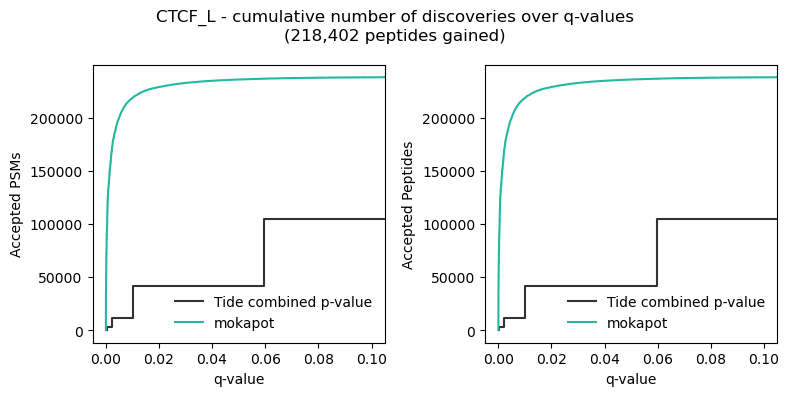

In [242]:
# plot test data
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
colors = ("#343131", "#24B8A0")

# Plot the performance:
for ax, level in zip(axs, tide_conf.levels):
    tide_conf.plot_qvalues(level=level, c=colors[0], ax=ax,
                           label="Tide combined p-value")
    moka_conf.plot_qvalues(level=level, c=colors[1], ax=ax,
                           label="mokapot")
    ax.legend(frameon=False)

fig.suptitle("{} - cumulative number of discoveries over q-values\n({:,} peptides gained)".format(title, moka_peps))

plt.tight_layout()

# save fig
plt.savefig("{}/{}_mokapot_performance.pdf".format(data_dir, title))

plt.show()

In [226]:
moka_conf

A mokapot.confidence.LinearConfidence object:
	- PSMs at q<=0.05: 235825
	- Peptides at q<=0.05: 235825

In [229]:
# save output
output_dir = data_dir
file_root = "CTCF_L"
result_files = moka_conf.to_txt(dest_dir=output_dir, file_root=file_root)
result_files

['/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_L.mokapot.psms.txt',
 '/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_L.mokapot.peptides.txt']

## looking at res

In [283]:
# CTCF L (best footprint according to Andrew)
data_type = "positive"
motif_type = "L"
data_file = "{}/CTCF_{}_m6a_fiberseq_{}_100bp_features.txt".format(data_dir, data_type, motif_type)

In [284]:
os.path.basename(data_file)

'CTCF_positive_m6a_fiberseq_L_100bp_features.txt'

In [288]:
"{}/CTCF_merged_100bp_features{}.pin".format(data_dir, "_".join(filter(None, (motif_type, data_type))))

'/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_merged_100bp_featuresL_positive.pin'

In [ ]:
"{}/CTCF_merged_100bp_features{}.pin".format(data_dir, "_".join(filter(None, (motif_type, data_type))))

In [286]:
'_'.join(filter(None, (motif_type, data_type)))

'L_positive'

In [275]:
moka_conf

A mokapot.confidence.LinearConfidence object:
	- PSMs at q<=0.05: 235825
	- Peptides at q<=0.05: 235825

In [256]:
models

(A trained mokapot.model.Model object:
 	estimator: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='auc', feature_types=None, gamma=1, gpu_id=-1,
               grow_policy='depthwise', importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=3,
               missing=nan, monotone_constraints='()', n_estimators=100,
               n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)
 	scaler: StandardScaler()
 	features: ['msp_size', 'left_m6a_count', 'right_m6a_count', 'motif_m6a_count', 'left_AT_count', 'right_AT_count', 'motif_AT_count', 'left_AT_prop', 'right_AT_prop', 'motif_AT_prop', 'left_m6a_pro

In [264]:
train.Label.value_counts()

 1    238348
-1     65943
Name: Label, dtype: int64

In [265]:
moka_conf.psms.head()

,SpecID,Label,Peptide,scannr,mokapot score,mokapot q-value,mokapot PEP,Proteins
0,26783,True,26783,26783,1.0,0.000032,0.001743,26783
1,127956,True,127956,127956,1.0,0.000032,0.001743,127956
2,127916,True,127916,127916,1.0,0.000032,0.001743,127916
3,127949,True,127949,127949,1.0,0.000032,0.001743,127949
4,204541,True,204541,204541,1.0,0.000032,0.001743,204541


# merge with ft center data


1. add mokapot q-value column to ft center table
2. map SpecID in pin back to individual pin files (pos, neg)
3. get motif_name and query_name from feature txt table
4. load ft center output table
5. concat mokapot q-value to ft center table using motif_name and query_name

In [7]:
# input feature files
motif_type = "L"
file_root = motif_type

dataset_type = "positive"
pos_file = "{}/CTCF_m6a_fiberseq_{}_100bp_{}_features-motif_query.txt".format(data_dir, motif_type, dataset_type)
print("Positive file: {}".format(os.path.basename(pos_file)))
df_pos = pd.read_csv(pos_file, sep="\t",)
print("Positive features - rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))
print("\n")

dataset_type = "small_negative"
neg_file = "{}/CTCF_m6a_fiberseq_{}_100bp_{}_features-motif_query.txt".format(data_dir, motif_type, dataset_type)
print("Negative file: {}".format(os.path.basename(neg_file)))
df_neg = pd.read_csv(neg_file, sep="\t",)
print("Negative - rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))

Positive file: CTCF_m6a_fiberseq_L_100bp_positive_features-motif_query.txt
Positive features - rows: 238,348 | cols: 129


Negative file: CTCF_m6a_fiberseq_L_100bp_small_negative_features-motif_query.txt
Negative - rows: 65,943 | cols: 129


In [ ]:
# mokapot output file
res_file = "{}/CTCF_{}.mokapot.psms.txt".format(data_dir, file_root)


In [266]:
print(pin_file)

/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_m6a_fiberseq_L_100bp_features.pin


In [268]:
train.head()

,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop,Peptide,Proteins,scannr
0,0,1,200.0,13.0,13.0,3.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,0,0,0
1,1,1,212.0,12.0,12.0,4.0,18.0,18.0,13.0,0.45,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,1,1,1
2,2,1,181.0,10.0,12.0,2.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,2,2,2
3,3,1,134.0,9.0,11.0,8.0,18.0,18.0,13.0,0.45,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,3,3,3
4,4,1,194.0,12.0,12.0,1.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,4,4,4


In [269]:
# read in positive feature data

data_type = "positive"
motif_type = "L"
data_file = "{}/CTCF_{}_m6a_fiberseq_{}_100bp_features.txt".format(data_dir, data_type, motif_type)

In [270]:
%%time

# read in feature df
n_rows = None
df_pos = pd.read_csv(data_file, sep="\t", nrows=n_rows)
print("rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))

rows: 238,348 | cols: 128
CPU times: user 1.51 s, sys: 92.6 ms, total: 1.6 s
Wall time: 1.61 s


In [271]:
df_pos.head()

,motif_name,query_name,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TGT_count,TGT_m6a_prop,TTA_count,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop
0,chr10_100338605_+,m54329U_210323_190418/12585455/ccs,200.0,13.0,13.0,3.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333
1,chr10_100338605_+,m54329U_210323_190418/16515087/ccs,212.0,12.0,12.0,4.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667
2,chr10_100338605_+,m54329U_210323_190418/169477611/ccs,181.0,10.0,12.0,2.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000
3,chr10_100338605_+,m54329U_210323_190418/173999297/ccs,134.0,9.0,11.0,8.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667
4,chr10_100338605_+,m54329U_210323_190418/180160021/ccs,194.0,12.0,12.0,1.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333


In [272]:
d_pos = df_pos.copy(deep=True)

# add Label col of 0's
d_pos.insert(1, "Label", 0)

# make Label value 1 for positive data
d_pos["Label"] = d_pos["Label"].replace(0, 1)
print("rows: {:,} | cols: {:,}".format(d_pos.shape[0], d_pos.shape[1]))

rows: 238,348 | cols: 129


In [274]:
d_pos.head()

,motif_name,Label,query_name,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,...,TGT_count,TGT_m6a_prop,TTA_count,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop
0,chr10_100338605_+,1,m54329U_210323_190418/12585455/ccs,200.0,13.0,13.0,3.0,18.0,18.0,13.0,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333
1,chr10_100338605_+,1,m54329U_210323_190418/16515087/ccs,212.0,12.0,12.0,4.0,18.0,18.0,13.0,...,0.0,0.0,1.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667
2,chr10_100338605_+,1,m54329U_210323_190418/169477611/ccs,181.0,10.0,12.0,2.0,18.0,18.0,13.0,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000
3,chr10_100338605_+,1,m54329U_210323_190418/173999297/ccs,134.0,9.0,11.0,8.0,18.0,18.0,13.0,...,0.0,0.0,1.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667
4,chr10_100338605_+,1,m54329U_210323_190418/180160021/ccs,194.0,12.0,12.0,1.0,18.0,18.0,13.0,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333


In [277]:
# confidence estimates based on the best original feature
tide_conf = train_psms.assign_confidence()

In [279]:
tide_conf

A mokapot.confidence.LinearConfidence object:
	- PSMs at q<=0.01: 11596
	- Peptides at q<=0.01: 11596

In [280]:
tide_conf.levels

['psms', 'peptides', 'proteins']